# GRU Model

## Data Import

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Precision, Recall, AUC, Accuracy
from keras.models import Sequential
from sklearn.preprocessing import normalize, StandardScaler
from keras_tuner.tuners import RandomSearch
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

## Data Preparation

In [19]:
df_train = pd.read_csv("dataset/output/no-oversampling/train.csv")
df_test = pd.read_csv("dataset/output/test.csv")

In [3]:
# split into X_train, y_train, X_test, y_test
X_train = df_train.drop(columns=["target"])
y_train = df_train["target"]
X_test = df_test.drop(columns=["target"])
y_test = df_test["target"]

# # normalize data
# X_train = normalize(X_train)
# X_test = normalize(X_test)
# y_train = normalize(y_train.values.reshape(-1, 1))
# y_test = normalize(y_test.values.reshape(-1, 1))

In [20]:
scaler = StandardScaler()
train_features = scaler.fit_transform(X_train)
test_features = scaler.fit_transform(X_test)

sequence_length = 10
batch_size = 32

train_sequences = []
test_sequences = []

for i in range(len(train_features) - sequence_length + 1):
    train_sequences.append(train_features[i:i + sequence_length])
xtrain = np.array(train_sequences)
ytrain = y_train[sequence_length - 1:]


for i in range(len(test_features) - sequence_length + 1):
    test_sequences.append(test_features[i:i + sequence_length])
xtest = np.array(test_sequences)
ytest = y_test[sequence_length - 1:]

## Helper Functions

In [21]:
# This plots the auc against iteration to detect overfitting
def plot_hist(hist, metric="accuracy"):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return

## Model Building
### Base Model

In [22]:
def create_gru_model(sequence_length, num_features):
    model = Sequential()
    model.add(GRU(32, input_shape=(sequence_length, num_features), dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
    return model

In [23]:
# Create and compile the model
sequence_length, num_features = sequence_length, X_train.shape[1]
model = create_gru_model(sequence_length, num_features)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 32)                4032      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(xtrain, ytrain, batch_size=batch_size, epochs=100, validation_data=(xtest, ytest))

Epoch 1/100
280/280 [==============================] - 3s 6ms/step - loss: 0.6532 - accuracy: 0.6293 - precision_1: 0.5169 - recall_1: 0.1189 - val_loss: 0.6282 - val_accuracy: 0.6713 - val_precision_1: 0.6578 - val_recall_1: 0.1551
Epoch 2/100
280/280 [==============================] - 1s 4ms/step - loss: 0.6425 - accuracy: 0.6477 - precision_1: 0.6358 - recall_1: 0.1336 - val_loss: 0.6262 - val_accuracy: 0.6713 - val_precision_1: 0.6513 - val_recall_1: 0.1602
Epoch 3/100
280/280 [==============================] - 1s 4ms/step - loss: 0.6412 - accuracy: 0.6477 - precision_1: 0.6332 - recall_1: 0.1356 - val_loss: 0.6281 - val_accuracy: 0.6722 - val_precision_1: 0.6533 - val_recall_1: 0.1639
Epoch 4/100
280/280 [==============================] - 1s 5ms/step - loss: 0.6399 - accuracy: 0.6439 - precision_1: 0.6034 - recall_1: 0.1368 - val_loss: 0.6265 - val_accuracy: 0.6717 - val_precision_1: 0.6807 - val_recall_1: 0.1425
Epoch 5/100
280/280 [==============================] - 1s 4ms/step -

280/280 [==============================] - 1s 5ms/step - loss: 0.6287 - accuracy: 0.6516 - precision_1: 0.6212 - recall_1: 0.1730 - val_loss: 0.6281 - val_accuracy: 0.6682 - val_precision_1: 0.5903 - val_recall_1: 0.2144
Epoch 37/100
280/280 [==============================] - 1s 5ms/step - loss: 0.6261 - accuracy: 0.6576 - precision_1: 0.6440 - recall_1: 0.1864 - val_loss: 0.6278 - val_accuracy: 0.6682 - val_precision_1: 0.6024 - val_recall_1: 0.1929
Epoch 38/100
280/280 [==============================] - 1s 5ms/step - loss: 0.6260 - accuracy: 0.6549 - precision_1: 0.6281 - recall_1: 0.1867 - val_loss: 0.6305 - val_accuracy: 0.6655 - val_precision_1: 0.5943 - val_recall_1: 0.1828
Epoch 39/100
280/280 [==============================] - 1s 5ms/step - loss: 0.6269 - accuracy: 0.6551 - precision_1: 0.6321 - recall_1: 0.1837 - val_loss: 0.6292 - val_accuracy: 0.6646 - val_precision_1: 0.5866 - val_recall_1: 0.1879
Epoch 40/100
280/280 [==============================] - 1s 4ms/step - loss: 0

280/280 [==============================] - 1s 4ms/step - loss: 0.6138 - accuracy: 0.6619 - precision_1: 0.6286 - recall_1: 0.2321 - val_loss: 0.6295 - val_accuracy: 0.6637 - val_precision_1: 0.5755 - val_recall_1: 0.2018
Epoch 72/100
280/280 [==============================] - 1s 4ms/step - loss: 0.6166 - accuracy: 0.6596 - precision_1: 0.6183 - recall_1: 0.2318 - val_loss: 0.6283 - val_accuracy: 0.6614 - val_precision_1: 0.5615 - val_recall_1: 0.2131
Epoch 73/100
280/280 [==============================] - 1s 5ms/step - loss: 0.6151 - accuracy: 0.6634 - precision_1: 0.6344 - recall_1: 0.2333 - val_loss: 0.6288 - val_accuracy: 0.6579 - val_precision_1: 0.5455 - val_recall_1: 0.2194
Epoch 74/100
280/280 [==============================] - 1s 5ms/step - loss: 0.6145 - accuracy: 0.6618 - precision_1: 0.6211 - recall_1: 0.2429 - val_loss: 0.6303 - val_accuracy: 0.6579 - val_precision_1: 0.5425 - val_recall_1: 0.2333
Epoch 75/100
280/280 [==============================] - 1s 5ms/step - loss: 0

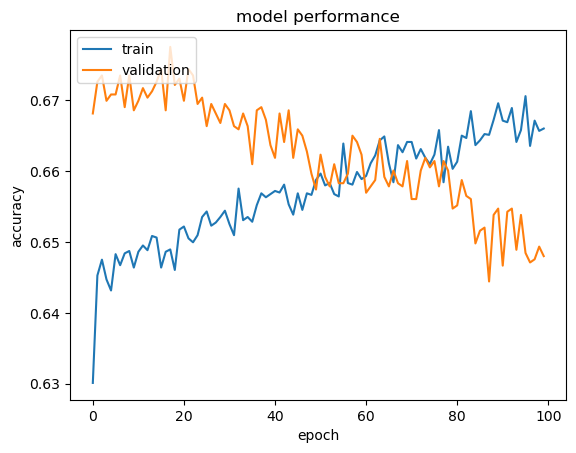

In [9]:
plot_hist(history)

In [10]:
y_pred = model.predict(xtest)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(ytest, y_pred)
print("Accuracy: ", accuracy_score(ytest, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(ytest, y_pred))

70/70 [==============================] - 0s 1ms/step
Accuracy:  0.6480071652485445

Confusion Matrix: 
 [[1266  174]
 [ 612  181]]

classification_report: 
               precision    recall  f1-score   support

         0.0       0.67      0.88      0.76      1440
         1.0       0.51      0.23      0.32       793

    accuracy                           0.65      2233
   macro avg       0.59      0.55      0.54      2233
weighted avg       0.62      0.65      0.60      2233



### Tuned Model

In [35]:
def build_model(hp):
    model = Sequential()
    model.add(GRU(
        units=hp.Int("units", min_value=32, max_value=256, step=32),
        return_sequences=False,
        input_shape=(sequence_length, X_train.shape[1]),
    ))
    model.add(Dropout(hp.Float("dropout_1", min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=hp.Choice("optimizer", ["adam", "rmsprop", "sgd"]),
        loss=hp.Choice("loss", ["binary_crossentropy", "mean_squared_error"]),
        metrics=["accuracy", Precision(), Recall()],
    )
    return model

In [36]:
# RandomSearch to find the best hyperparameters
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,  # Adjust the number of trials as needed
    directory='gru',
    project_name='gru'
)

tuner.search(
    xtrain,
    ytrain,
    validation_data=(xtest, ytest),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
)

Trial 30 Complete [00h 00m 07s]
val_accuracy: 0.6480071544647217

Best val_accuracy So Far: 0.6771159768104553
Total elapsed time: 00h 02m 07s
INFO:tensorflow:Oracle triggered exit


In [39]:
# get params of best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units': 128,
 'dropout_1': 0.2,
 'optimizer': 'adam',
 'loss': 'binary_crossentropy'}

In [40]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               52992     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 53,121
Trainable params: 53,121
Non-trainable params: 0
_________________________________________________________________


In [41]:
# build and fit best model
best_model.build(xtrain.shape)
history = best_model.fit(xtrain, ytrain, batch_size=batch_size, epochs=100, validation_data=(xtest, ytest))

Epoch 1/100
280/280 [==============================] - 4s 8ms/step - loss: 0.6392 - accuracy: 0.6484 - precision: 0.6221 - recall: 0.1500 - val_loss: 0.6251 - val_accuracy: 0.6695 - val_precision: 0.6519 - val_recall: 0.1488
Epoch 2/100
280/280 [==============================] - 2s 7ms/step - loss: 0.6377 - accuracy: 0.6501 - precision: 0.6332 - recall: 0.1506 - val_loss: 0.6251 - val_accuracy: 0.6686 - val_precision: 0.6178 - val_recall: 0.1753
Epoch 3/100
280/280 [==============================] - 2s 7ms/step - loss: 0.6366 - accuracy: 0.6469 - precision: 0.6090 - recall: 0.1536 - val_loss: 0.6265 - val_accuracy: 0.6735 - val_precision: 0.6495 - val_recall: 0.1753
Epoch 4/100
280/280 [==============================] - 2s 8ms/step - loss: 0.6362 - accuracy: 0.6500 - precision: 0.6254 - recall: 0.1572 - val_loss: 0.6254 - val_accuracy: 0.6708 - val_precision: 0.6272 - val_recall: 0.1803
Epoch 5/100
280/280 [==============================] - 2s 8ms/step - loss: 0.6341 - accuracy: 0.6488

280/280 [==============================] - 2s 8ms/step - loss: 0.0611 - accuracy: 0.9798 - precision: 0.9723 - recall: 0.9737 - val_loss: 2.0541 - val_accuracy: 0.5714 - val_precision: 0.3938 - val_recall: 0.3834
Epoch 38/100
280/280 [==============================] - 2s 7ms/step - loss: 0.0511 - accuracy: 0.9865 - precision: 0.9835 - recall: 0.9803 - val_loss: 2.1590 - val_accuracy: 0.5737 - val_precision: 0.3992 - val_recall: 0.3972
Epoch 39/100
280/280 [==============================] - 2s 7ms/step - loss: 0.0471 - accuracy: 0.9866 - precision: 0.9835 - recall: 0.9806 - val_loss: 2.2309 - val_accuracy: 0.5822 - val_precision: 0.4093 - val_recall: 0.3985
Epoch 40/100
280/280 [==============================] - 2s 7ms/step - loss: 0.0384 - accuracy: 0.9894 - precision: 0.9857 - recall: 0.9860 - val_loss: 2.3074 - val_accuracy: 0.5687 - val_precision: 0.3973 - val_recall: 0.4149
Epoch 41/100
280/280 [==============================] - 2s 7ms/step - loss: 0.0402 - accuracy: 0.9876 - preci

280/280 [==============================] - 2s 7ms/step - loss: 0.0052 - accuracy: 0.9993 - precision: 0.9988 - recall: 0.9994 - val_loss: 3.2762 - val_accuracy: 0.5817 - val_precision: 0.4046 - val_recall: 0.3770
Epoch 74/100
280/280 [==============================] - 2s 7ms/step - loss: 0.0086 - accuracy: 0.9973 - precision: 0.9961 - recall: 0.9967 - val_loss: 3.2323 - val_accuracy: 0.5790 - val_precision: 0.3995 - val_recall: 0.3682
Epoch 75/100
280/280 [==============================] - 2s 7ms/step - loss: 0.0391 - accuracy: 0.9886 - precision: 0.9851 - recall: 0.9845 - val_loss: 3.2499 - val_accuracy: 0.5822 - val_precision: 0.4028 - val_recall: 0.3657
Epoch 76/100
280/280 [==============================] - 2s 7ms/step - loss: 0.0291 - accuracy: 0.9907 - precision: 0.9886 - recall: 0.9866 - val_loss: 3.2309 - val_accuracy: 0.5750 - val_precision: 0.4035 - val_recall: 0.4111
Epoch 77/100
280/280 [==============================] - 2s 8ms/step - loss: 0.0251 - accuracy: 0.9922 - preci

In [ ]:
plot_hist(history)

In [ ]:
y_pred = model.predict(xtest)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(ytest, y_pred)
print("Accuracy: ", accuracy_score(ytest, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(ytest, y_pred))